Name: George Downing\
PI: J7526527

# TreeSat Species Classifications
# Sample notebook

This notebook shows you how to use the TreeSat dataset. It takes you through 
* loading the data into three datasets (for training, validation, and testing)
* how to create, train, save, and evaluate a sample model using this data.

You should use this notebook as the basis for your own investigations of this data. We advise you to make a copy of this notebook for each experiment you perform with this dataset.

## Performance Tips

This dataset is large, and comprises large images. Models may take a long time to train, and may fail with out-of-memory errors.

General tips:

* If you create a modified dataset, don't `cache()` that dataset: it will be too large to fit in memory.
* If you create a modified dataset and want to `shuffle()` it, do the shuffling _after_ any `batch()` operation, and use a shuffle buffer size appropriate for the number of _batches_ (not images) in the dataset.

When you are exploring possible approaches to the EMA, you may want to test the viability of an approach by running small experiments before committing to long training runs. Ways of speeding things up include:
* using only a fraction of the data (use `train_file_labels.shard()`)
* using smaller images (use `IMAGE_RESCALE`)
* increasing the `BATCH_SIZE`

If training fails with out-of-memory issues, consider:
* using smaller images (use `IMAGE_RESCALE`)
* decreasing the `BATCH_SIZE`
* using a simpler model

Finally, with long-duration timing runs, the Jupyter front end can get confused with updating progress bars and then refuse to update the front end at all. It's best to train for an epoch or two with `verbose=1` to check things are working, then redo the full training run with `verbose=0` to ensure you can see outuput in the notebook later.

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import csv
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

# Data format and structure

The dataset contains just over 50,000 images, each showing a 60m × 60m region of a forest in Germany. Each image shows mainly one species of tree. There are three levels of label for each image: the English name (level 3), forest management class (level 2), and leaf type (level 1).

![Treesat label levels](treesat_label_levels.png)
> Image detail from Ahlswede _et al._ (2023) figure 4.

The dataset has been split into 70% training, 10% validation, and 20% testing images.

The images are 304 × 304 pixels and encoded as four-channel PNG images. We are mis-using the PNG's alpha (transparency) channel to represent the near-IR light band in the original images.

The data resides in the `/datasets/treesat/` directory. All the images are in the `/datasets/treesat/images/` directory. There are three `.csv` files that specify which images are in which split of the dataset. There are three text files that list the different labels at each level.

In [2]:
!ls /datasets/treesat

images			level_3_vocabulary.txt	validation_file_labels.csv
level_1_vocabulary.txt	test_file_labels.csv
level_2_vocabulary.txt	train_file_labels.csv


If we look at one of the `.csv` files, we can see the image name and labels at each level.

In [3]:
!head /datasets/treesat/train_file_labels.csv

Similarly, we can see the distinct labels at each level.

In [4]:
!cat /datasets/treesat/level_2_vocabulary.txt

larch
cleared
beech
oak
douglas fir
pine
fir
short-lived deciduous
long-lived deciduous
spruce


# Defining constants

`label_level` is one of 1, 2, or 3, and is the level of labels used in this notebook.

In [5]:
data_dir = '/datasets/treesat'
label_level = 2

In [6]:
IMAGE_RESCALE = (152, 152)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 4)
batch_size = 128
label_key = f'level_{label_level}'

# Loading data

First, we load the image names and labels into the `file_label` datasets. 

In [7]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_file_labels.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [8]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'validation_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
validation_file_labels = validation_file_labels.unbatch()

In [9]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
test_file_labels = test_file_labels.unbatch()

We load the vocabulary for this level of labels and create a `StringLookup` encoder that will convert each label into a one-hot vector.

In [10]:
encoder_vocab_file = os.path.join(data_dir, f'level_{label_level}_vocabulary.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'larch',
 1: 'cleared',
 2: 'beech',
 3: 'oak',
 4: 'douglas fir',
 5: 'pine',
 6: 'fir',
 7: 'short-lived deciduous',
 8: 'long-lived deciduous',
 9: 'spruce'}

With the labels defined, we know enough to pretty-print a confusion matrix.

In [11]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += f'<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan={len(label_lookup)}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(label_lookup.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += f'<th rowspan={len(label_lookup) + 1}>Actual labels</th>\n'

    for ai, an in sorted(label_lookup.items()):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(label_lookup.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

We have a function that take a filename and text label and returns the image and one-hot encoded label.

In [12]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=4)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

## Loading the images

Now we can load the images into datasets.

In [13]:
train_data = train_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(200)
train_data = train_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [14]:
validation_data = validation_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [15]:
test_data = test_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Exploring the data

We can now explore some elements of the data, such as some sample images and the distribution of classes.

## Distribution of classes

In [16]:
class_counts = train_file_labels.map(lambda fl: label_encoder(fl[label_key]))
class_counts = class_counts.reduce(tf.zeros((num_classes,)),
                             lambda o, l: tf.math.add(o, l))
class_counts

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2145., 2844., 4508., 5515., 1896., 5324.,  687., 4131., 4118.,
       4098.], dtype=float32)>

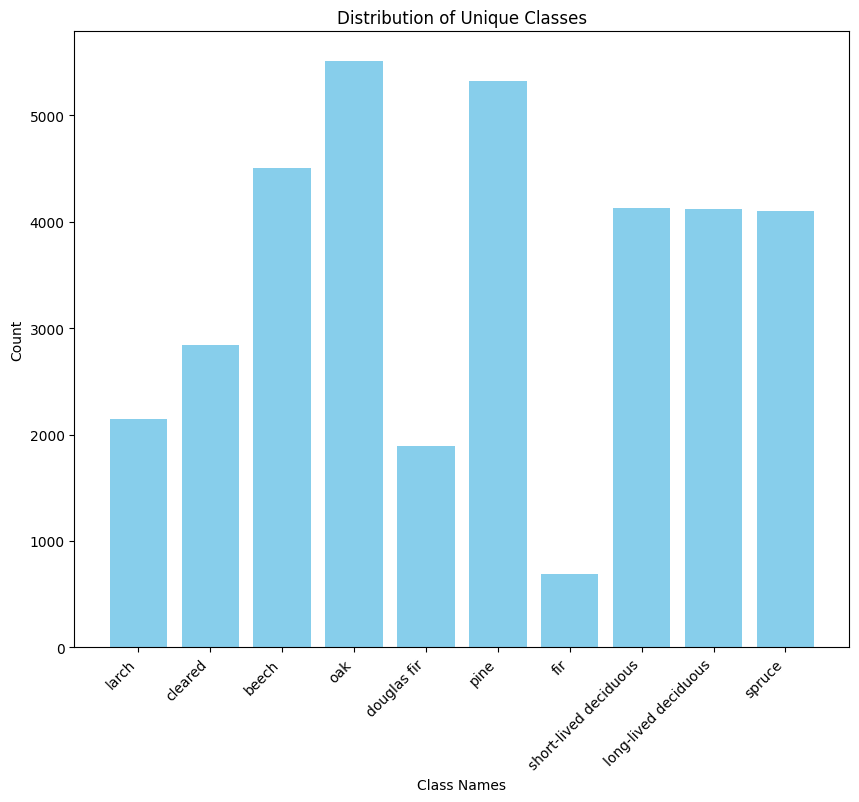

In [17]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), class_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

## Show some sample images

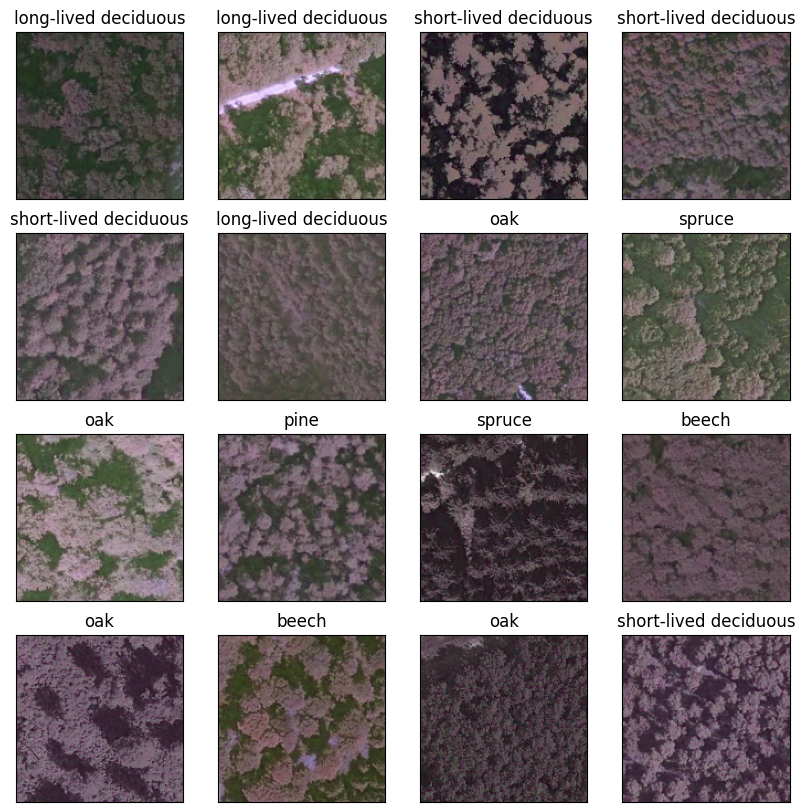

In [19]:
sample_images, sample_labels = train_data.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(16):  # Adjust this number based on how many images you want to display
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i, ..., :-1]) # drop the alpha channel, to make the images more like you'd see
#     plt.imshow(sample_images[i]) # image with alpha channel
    label_index = np.argmax(sample_labels[i])
    class_name = label_lookup[label_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_name)

# Create and train a sample model

This is a a trivial model just to demonstrate the use of the datasets. 

In [19]:
model_sample = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
   
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_sample.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 8)       808       
                                                                 
 conv2d_1 (Conv2D)           (None, 304, 304, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dense (Dense)               (None, 128)               5914752   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [20]:
model_sample.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model_sample.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
276/276 [==============================] - 91s 304ms/step - loss: 2.0517 - accuracy: 0.2527 - val_loss: 1.8656 - val_accuracy: 0.3239
Epoch 2/5
276/276 [==============================] - 81s 294ms/step - loss: 1.7524 - accuracy: 0.3721 - val_loss: 1.9021 - val_accuracy: 0.3235
Epoch 3/5
276/276 [==============================] - 81s 293ms/step - loss: 1.5518 - accuracy: 0.4554 - val_loss: 1.6601 - val_accuracy: 0.4095
Epoch 4/5
276/276 [==============================] - 81s 293ms/step - loss: 1.2776 - accuracy: 0.5640 - val_loss: 1.6943 - val_accuracy: 0.4109
Epoch 5/5
276/276 [==============================] - 81s 293ms/step - loss: 0.9609 - accuracy: 0.6812 - val_loss: 1.9728 - val_accuracy: 0.3724


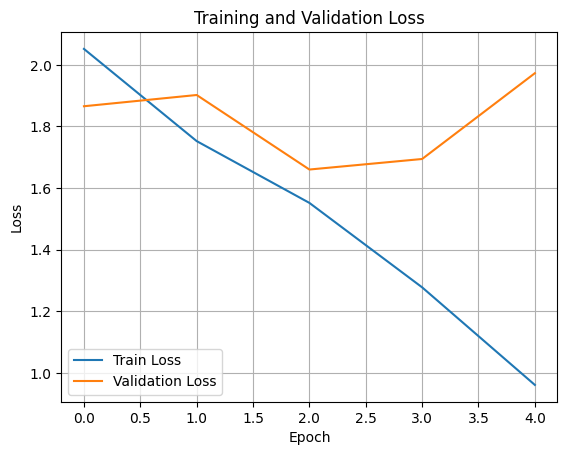

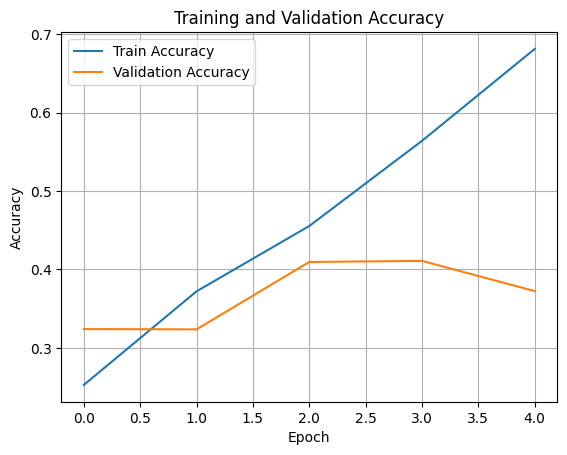

In [22]:
import matplotlib.pyplot as plt

# Assuming history contains the training history returned by model.fit
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Cache results for later

In [23]:
model_sample.save('example_model.keras')

with open('example_model_history.json', 'w') as f:
    json.dump(history.history, f)

In [24]:
model_sample = tf.keras.models.load_model('example_model.keras')

with open('example_model_history.json') as f:
    example_history = json.load(f)

## Evaluating the model

In [27]:
model_sample.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 240ms/step - loss: 1.9814 - accuracy: 0.3816


{'loss': 1.9814265966415405, 'accuracy': 0.3815619647502899}

In [28]:
test_predictions = model_sample.predict(test_data)

79/79 [==============================] - 16s 202ms/step


In [29]:
predict_labels = np.argmax(test_predictions, axis=1)

In [30]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [31]:
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

# My Work

## Data Augmentation

Another method that could improve performance is data augmentation. This will generate additional labelled data to help prevent overfitting and potentially improve performance.

To augment the data we will use horizontal translation and rotation. The first step is to use the code below to define that we will translate the data with a height and width factor of 0.2, and rotate the data with a rotation factor of 0.1

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  layers.RandomRotation(0.1)
])

Next we will apply this augmentation to the training data with the code below.

In [17]:
aug_train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
import gc
del train_data
gc.collect()

1526

Now we have the augmented data we can retrain the previous models using this data to see whether it improves performance.

### baseline model

First we will create a new model in the same form as the baseline model, but specifying this new model will be trained on the augmented dataset.

In [19]:
aug_model_0 = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
aug_model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 152, 152, 8)       808       
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2  (None, 38, 38, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 4)         804       
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 4)         404       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 4)           0         
 g2D)                                                 

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer. Then we will train the model on the weighted augmented training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [20]:
aug_model_0.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

aug_model_0_history = aug_model_0.fit(
    aug_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-24 16:42:31.762444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [21]:
aug_model_0.save('aug_model_0_review_25_now.keras')
with open('aug_model_0_review_history_25_now.json', 'w') as f:
    json.dump(aug_model_0_history.history, f)

Next I will reload the model and it's history with the code below.

In [22]:
aug_model_0 = tf.keras.models.load_model('aug_model_0_review_25_now.keras')
with open('aug_model_0_review_history_25_now.json') as f:
    aug_model_0_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

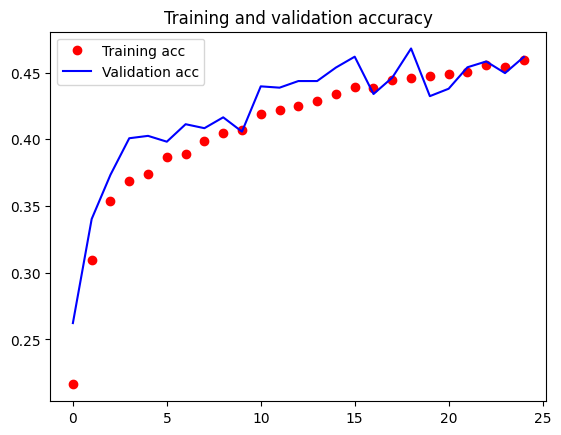

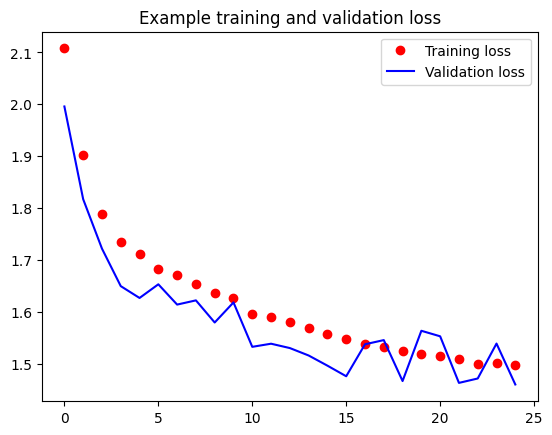

In [23]:
acc = aug_model_0_history['accuracy']
val_acc = aug_model_0_history['val_accuracy']
loss = aug_model_0_history['loss']
val_loss = aug_model_0_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. Throughout the training the results from the validation data and the training data are reasonably similar which suggests that the model is not overfitting. The model is still improving at the end of the training period, even though the rate of improvement is decreasing, suggesting that the model may benefit from further training. However, the loss for training and validation appear to be separating so more training may lead to overfitting.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [25]:
aug_model_0.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 235ms/step - loss: 1.4578 - accuracy: 0.4704


{'loss': 1.4578288793563843, 'accuracy': 0.4703781008720398}

In [27]:
test_predictions_aug_0 = aug_model_0.predict(test_data)

79/79 [==============================] - 17s 209ms/step


In [28]:
predict_labels_aug_0 = np.argmax(test_predictions_aug_0, axis=1)

In [29]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [30]:
cm_0 = tf.math.confusion_matrix(test_labels, predict_labels_aug_0).numpy()
pretty_cm(cm_0)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [31]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_0[i, i]
    
    FN = np.sum(cm_0[i, :]) - TP
    
    FP = np.sum(cm_0[:, i]) - TP
    
    TN = np.sum(cm_0) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.4795770371687393
Average Recall: 0.39145830945617355


The model has an accuracy of 47% when evaluated on the test data. We can see from the confusion matrix that the columns for beech and oak tend to be the largest, suggesting the model is overpredicting these trees. The model had a precision of 58% and a recall of 39%.

### model_filter

First we will create a new model in the same form as model_filter, but specifying this new model will be trained on the augmented dataset.

In [19]:
aug_model_filter = Sequential([
    Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
aug_model_filter.summary()

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer. Then we will train the model on the weighted augmented training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [20]:
aug_model_filter.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

aug_model_filter_history = aug_model_filter.fit(
    aug_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

In [21]:
aug_model_filter.save('aug_model_filter_review_25_now.keras')
with open('aug_model_filter_review_history_25_now.json', 'w') as f:
    json.dump(aug_model_filter_history.history, f)

Next I will reload the model and it's history with the code below.

In [19]:
aug_model_filter = tf.keras.models.load_model('aug_model_filter_review_25_now.keras')
with open('aug_model_filter_review_history_25_now.json') as f:
    aug_model_filter_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

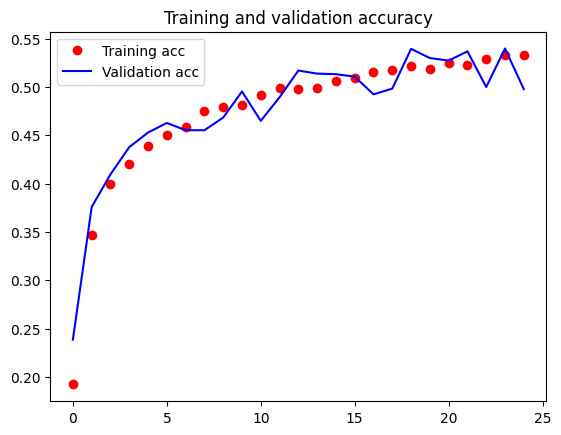

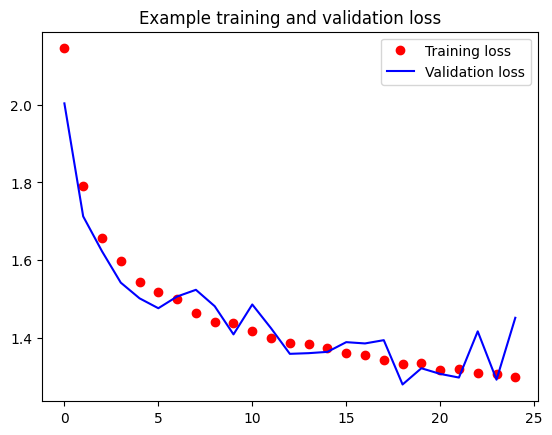

In [20]:
acc = aug_model_filter_history['accuracy']
val_acc = aug_model_filter_history['val_accuracy']
loss = aug_model_filter_history['loss']
val_loss = aug_model_filter_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. Throughout the training the results from the validation data and the training data are reasonably similar which suggests that the model is not overfitting. The model is still improving at the end of the training period, even though the rate of improvement is decreasing, suggesting that the model may benefit from further training. However, the loss for training and validation appear to be separating so more training may lead to overfitting.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [20]:
aug_model_filter.evaluate(test_data, return_dict=True)

79/79 [==============================] - 22s 244ms/step - loss: 1.4558 - accuracy: 0.4871


{'loss': 1.4557522535324097, 'accuracy': 0.4871489405632019}

In [21]:
test_predictions_aug_filter = aug_model_filter.predict(test_data)

79/79 [==============================] - 19s 233ms/step


In [22]:
predict_labels_aug_filter = np.argmax(test_predictions_aug_filter, axis=1)

In [23]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [24]:
cm_filter = tf.math.confusion_matrix(test_labels, predict_labels_aug_filter).numpy()
pretty_cm(cm_filter)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [26]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_filter[i, i]
    
    FN = np.sum(cm_filter[i, :]) - TP
    
    FP = np.sum(cm_filter[:, i]) - TP
    
    TN = np.sum(cm_filter) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.5336352010392074
Average Recall: 0.4237684934225374


The model has an accuracy of 49% when evaluated on the test data. We can see from the confusion matrix that the columns for beech and oak tend to be the largest, suggesting the model is overpredicting these trees. The model had a precision of 53% and a recall of 42%.

### model_layers

Next we will create a new model in the same form as model_layers, but specifying this new model will be trained on the augmented dataset.

In [26]:
aug_model_layers = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
aug_model_layers.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7ff99432c0d0>>

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer. Then we will train the model on the weighted augmented training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [27]:
aug_model_layers.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

aug_model_layers_history = aug_model_filter.fit(
    aug_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-23 11:26:55.833958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [28]:
aug_model_layers.save('aug_model_layers_review_25_now.keras')
with open('aug_model_layers_review_history_25_now.json', 'w') as f:
    json.dump(aug_model_layers_history.history, f)

Next I will reload the model and it's history with the code below.

In [27]:
aug_model_layers = tf.keras.models.load_model('aug_model_layers_review_25_now.keras')
with open('aug_model_layers_review_history_25_now.json') as f:
    aug_model_layers_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

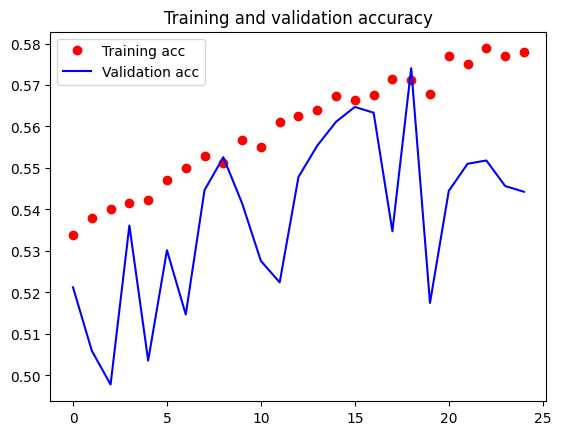

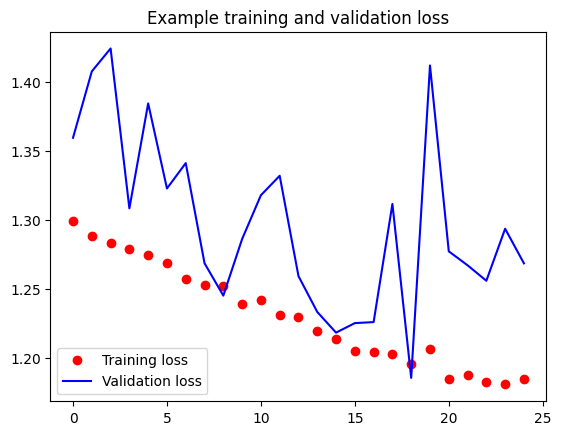

In [30]:
acc = aug_model_layers_history['accuracy']
val_acc = aug_model_layers_history['val_accuracy']
loss = aug_model_layers_history['loss']
val_loss = aug_model_layers_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. The model's training accuracy and loss appear to be oscillating around the same values for the last 5 epochs suggesting that the model will not improve from further training. The training and validation loss and accuracy are also beginning to separate from each other suggesting the model is beginning to overfit.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [31]:
aug_model_layers.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 224ms/step - loss: 2.3014 - accuracy: 0.0980


{'loss': 2.3013617992401123, 'accuracy': 0.09804505109786987}

In [28]:
test_predictions_aug_layers = aug_model_layers.predict(test_data)

79/79 [==============================] - 19s 230ms/step


In [29]:
predict_labels_aug_layers = np.argmax(test_predictions_aug_layers, axis=1)

In [30]:
cm_layers = tf.math.confusion_matrix(test_labels, predict_labels_aug_layers).numpy()
pretty_cm(cm_layers)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [31]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_layers[i, i]
    
    FN = np.sum(cm_layers[i, :]) - TP
    
    FP = np.sum(cm_layers[:, i]) - TP
    
    TN = np.sum(cm_layers) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.053302454467146966
Average Recall: 0.08689559156706882


The model has an accuracy of 10% when evaluated on the test data. We can see from the confusion matrix that the model is never predicting larch, douglas fir or pine trees, and rarely predicts deciduous trees. This is surprising as the training accuracy for this model was close to 58% after it was trained. This may suggest that the model is overfitted to the augmented data, and cannot apply the underlying learned factors onto the non augmented test dataset. The model had a precision of 5% and a recall of 8%.

### model_lr

Finally, we will create a new model in the same form as model_lr, but specifying this new model will be trained on the augmented dataset.

In [35]:
aug_model_lr = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
aug_model_lr.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 152, 152, 8)       808       
                                                                 
 conv2d_7 (Conv2D)           (None, 152, 152, 8)       1608      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 38, 38, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 38, 38, 4)         804       
                                                                 
 conv2d_9 (Conv2D)           (None, 38, 38, 4)         404       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 9, 9, 4)           0         
 g2D)                                                 

In [36]:
opt = optimizers.Adam(learning_rate=0.01)
opt.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.01,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with the newly created optimizer. Then we will train the model on the weighted augmented training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [37]:
aug_model_lr.compile(loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

aug_model_lr_history = aug_model_lr.fit(
    aug_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-23 12:40:50.399489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [38]:
aug_model_lr.save('aug_model_lr_review_25_now.keras')
with open('aug_model_lr_review_history_25_now.json', 'w') as f:
    json.dump(aug_model_lr_history.history, f)

Next I will reload the model and it's history with the code below.

In [32]:
aug_model_lr = tf.keras.models.load_model('aug_model_lr_review_25_now.keras')
with open('aug_model_lr_review_history_25_now.json') as f:
    aug_model_lr_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

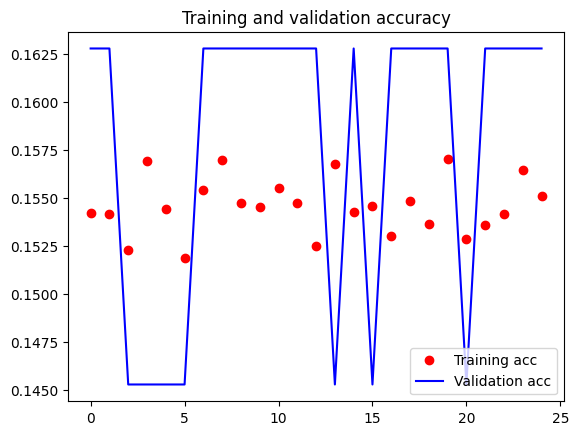

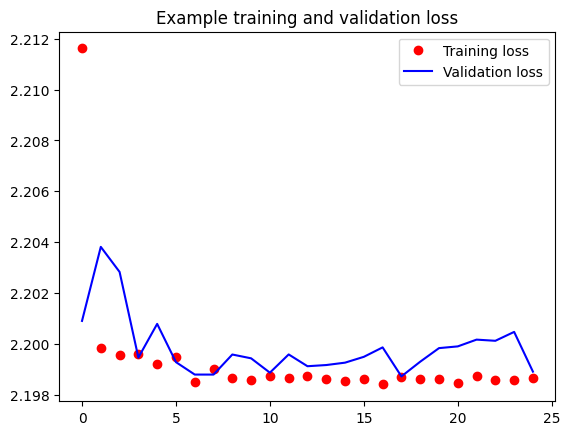

In [41]:
acc = aug_model_lr_history['accuracy']
val_acc = aug_model_lr_history['val_accuracy']
loss = aug_model_lr_history['loss']
val_loss = aug_model_lr_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have remained the same for both training and validation data over the training period. Throughout the training the results from the validation data and the training data appear to oscillate around the same values, suggesting that the model is overshooting the optimal rates and getting stuck at non optimal points.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [42]:
aug_model_lr.evaluate(test_data, return_dict=True)

79/79 [==============================] - 18s 224ms/step - loss: 2.2040 - accuracy: 0.1555


{'loss': 2.2039875984191895, 'accuracy': 0.15550263226032257}

In [33]:
test_predictions_aug_lr = aug_model_lr.predict(test_data)

79/79 [==============================] - 18s 228ms/step


In [34]:
predict_labels_aug_lr = np.argmax(test_predictions_aug_lr, axis=1)

In [45]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [35]:
cm_lr = tf.math.confusion_matrix(test_labels, predict_labels_aug_lr).numpy()
pretty_cm(cm_lr)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [36]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_lr[i, i]
    
    FN = np.sum(cm_lr[i, :]) - TP
    
    FP = np.sum(cm_lr[:, i]) - TP
    
    TN = np.sum(cm_lr) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.015550262975091794
Average Recall: 0.1


The model has an accuracy of 16% when evaluated on the test data. We can see from the confusion matrix that the model is only predicting oak trees, suggesting this is what the model has reached. This lines up with the accuracy being 16% as roughly 1/7 trees are oak trees. The model had a precision of 2% and a recall of 10%.